**Užduotys**

1.	Rasti, kiek iš viso registruota atvejų Vilniaus miesto savivaldybėje (municipality_code==13) 2021 m. vasario 9 dieną.
2.	Rasti, kurioje savivaldybėje yra daugiausia atvejų 80-ies ir vyresnių amžiaus grupėje  (t.y., age_bracket==”Virš 80”)
3.	Rasti, kiek iš viso registruota atvejų Lietuvoje 2021 m. vasario 9 dieną 
4.	Parašyti Python / Pyspark funkciją, kuri  grąžintų atfiltruotą duomenų rinkinį su atvejais, kurie užregistruoti šeštadieniais ir sekmadieniais.
5.	Sukurti Pyspark dataframe iš lentelės **amziaus_kategorijos.xlsx** (įkelkite šią lentelę į collab /content aplanką, žr. prie el. laiško prisegtą failą). Sujungti šią lentelę su lentele „COVID19 atvejai pagal lytį ir amžių“ naudojant join. Grąžinti 2021 m. vasario 9 d. atvejų kiekius, sugrupuotus pagal nurodytas amžiaus kategorijas. Pvz:

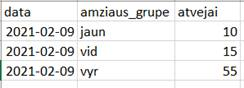

6.	(sudėtingesnė užduotis) Žr. 5) užduoties formuluotę. Grąžinti atvejus, sugrupuotus pagal nurodytas amžiaus kategorijas visoms datoms. Datos turi būti surikiuotos mažėjimo tvarka pvz.:

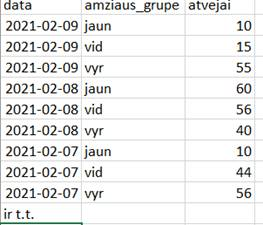

**Pastaba: Atlikdami užduotis naudokite PySpark. Kodas turėtų būti tvarkingas, lakoniškas, save komentuojantis, o išvesties rezultatai kokybiški.**


**Kodą rašykite čia**

In [ ]:
from pyspark.sql import functions as F, Row, SparkSession
from pyspark.sql.functions import*

spark = SparkSession.builder.master("local[*]").getOrCreate()


In [ ]:
spark

In [ ]:
covid_data=spark.read.option('header','true').option("delimiter",";").csv('covid_cases_opendata.csv',inferSchema=True)

In [ ]:
covid_data.show()

+---------+--------------------+-------------------+----------+-----------------+----------+-------+
|object_id|           case_code|         confirmati|municipali|       municipa_1|age_bracke| gender|
+---------+--------------------+-------------------+----------+-----------------+----------+-------+
|    91038|357bd6a710733ff74...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|     20-29|Moteris|
|    91039|ea7d07493157c9156...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|       0-9|  Vyras|
|    91040|57958d08dd6626841...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|     50-59|  Vyras|
|    91041|63c621502cbc64b5c...|2021.02.06 00:00:00|        94| Jurbarko r. sav.|     40-49|Moteris|
|    91042|a96956ee1dc38d672...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|     50-59|Moteris|
|    91043|adceabf3c03d5b848...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|     40-49|Moteris|
|    91044|64e1c2c4aa13b47d2...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|     70-79

In [ ]:
# 1.Rasti, kiek iš viso registruota atvejų Vilniaus miesto savivaldybėje (municipality_code==13) 2021 m. vasario 9 dieną.
covid_cases=covid_data.where((covid_data.municipali == '13') & (covid_data.confirmati == '2021.02.09 00:00:00')).count()
print(f"2021 vasario 9 dieną Vilniuje užfiksuota {covid_cases} COVID susirgimo atvejai")

2021 vasario 9 dieną Vilniuje užfiksuota 103 COVID susirgimo atvejai


In [ ]:
# 2.Rasti, kurioje savivaldybėje yra daugiausia atvejų 80-ies ir vyresnių amžiaus grupėje (t.y., age_bracket==”Virš 80”)
query = "SELECT COUNT(confirmati) AS susirgimu_kiekis, municipa_1 FROM COVID_DATA WHERE age_bracke == 'Virš 80' GROUP BY municipa_1"
covid_data.createOrReplaceTempView("COVID_DATA")
sql_table = spark.sql(query)
biggest_case = sql_table.orderBy(col("susirgimu_kiekis").desc())
biggest_case.show(1)

+----------------+----------------+
|susirgimu_kiekis|      municipa_1|
+----------------+----------------+
|            1571|Vilniaus m. sav.|
+----------------+----------------+
only showing top 1 row



In [ ]:
# 3.Rasti, kiek iš viso registruota atvejų Lietuvoje 2021 m. vasario 9 dieną 
covid_cases = covid_data.where(covid_data.confirmati == '2021.02.09 00:00:00').count()
print(f"2021 vasario 9 dieną Lietuvoje užfiksuota {covid_cases} COVID susirgimo atvejai")

2021 vasario 9 dieną Lietuvoje užfiksuota 569 COVID susirgimo atvejai


In [ ]:
# 4. Parašyti Python / Pyspark funkciją, kuri grąžintų atfiltruotą duomenų rinkinį su atvejais, kurie užregistruoti šeštadieniais ir sekmadieniais.
covid_table = covid_data.withColumn("data", covid_data.confirmati.substr(1,10)).withColumn('data', regexp_replace(col('data'), "\\.", "-"))

covid_table = covid_table.withColumn('data',to_date(covid_table.data, 'yyyy-MM-dd'))

covid_table = covid_table.withColumn('data',dayofweek(col("data")))
covid_table = covid_table.withColumnRenamed("data", "day_of_week_US")
covid_table = covid_table.withColumn("day_of_week_US",col("day_of_week_US").cast(StringType()))
weekend_covid_cases = covid_table.filter((covid_table.day_of_week_US == "7") | (covid_table.day_of_week_US == "1"))
weekend_covid_cases.show()


+---------+--------------------+-------------------+----------+-----------------+----------+-------+--------------+
|object_id|           case_code|         confirmati|municipali|       municipa_1|age_bracke| gender|day_of_week_US|
+---------+--------------------+-------------------+----------+-----------------+----------+-------+--------------+
|    91038|357bd6a710733ff74...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|     20-29|Moteris|             7|
|    91039|ea7d07493157c9156...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|       0-9|  Vyras|             7|
|    91040|57958d08dd6626841...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|     50-59|  Vyras|             7|
|    91041|63c621502cbc64b5c...|2021.02.06 00:00:00|        94| Jurbarko r. sav.|     40-49|Moteris|             7|
|    91042|a96956ee1dc38d672...|2021.02.06 00:00:00|        13| Vilniaus m. sav.|     50-59|Moteris|             7|
|    91043|adceabf3c03d5b848...|2021.02.06 00:00:00|        13| Vilniaus

**5 Užduotis**

In [ ]:
categories=spark.read.option('header','true').option("delimiter",";").csv('amziaus_kategorijos.csv',inferSchema=True)
categories.show()

+--------+-----------+
|category|age_bracket|
+--------+-----------+
|    jaun|        0-9|
|    jaun|      10-19|
|    jaun|      20-29|
|     vid|      30-39|
|     vid|      40-49|
|     vid|      50-59|
|     vyr|      60-69|
|     vyr|      70-79|
|     vyr|    Virš 80|
+--------+-----------+



In [ ]:
left_join = covid_data.join(categories, covid_data.age_bracke == categories.age_bracket,how='left').filter(covid_data.confirmati == "2021.02.09 00:00:00")

covid_cases = left_join.groupBy("category").count()

covid_cases.show()

+--------+-----+
|category|count|
+--------+-----+
|    jaun|  109|
|    null|    3|
|     vid|  291|
|     vyr|  166|
+--------+-----+



In [ ]:
right_table = left_join.select(col("confirmati"),col("category")).withColumnRenamed("category", "kategorija")

right_table.show()

+-------------------+----------+
|         confirmati|kategorija|
+-------------------+----------+
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|      jaun|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|       vyr|
|2021.02.09 00:00:00|      jaun|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|      jaun|
|2021.02.09 00:00:00|      jaun|
|2021.02.09 00:00:00|       vyr|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|      jaun|
|2021.02.09 00:00:00|       vid|
|2021.02.09 00:00:00|      jaun|
+-------------------+----------+
only showing top 20 rows



In [ ]:
left_join2 = covid_cases.join(right_table, covid_cases.category == right_table.kategorija,how='left').select(col("confirmati"),col("kategorija"),col("count"))

left_join2.show()

+-------------------+----------+-----+
|         confirmati|kategorija|count|
+-------------------+----------+-----+
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
|2021.02.09 00:00:00|      jaun|  109|
+-------------------+----------+-----+
only showing top 20 rows



In [ ]:
covid_by_age = left_join2.distinct().filter(left_join2.kategorija != "null").withColumnRenamed("confirmati", "data").withColumnRenamed("kategorija", "amžiaus_grupė")\
    .withColumnRenamed("count", "atvejai").withColumn('data', regexp_replace('data', '2021.02.09 00:00:00', '2021-02-09'))

covid_by_age.show()

+----------+-------------+-------+
|      data|amžiaus_grupė|atvejai|
+----------+-------------+-------+
|2021-02-09|         jaun|    109|
|2021-02-09|          vid|    291|
|2021-02-09|          vyr|    166|
+----------+-------------+-------+



**6 Užduotis **

In [ ]:
left_join3 = covid_data.join(categories, covid_data.age_bracke == categories.age_bracket,how='left').select(col("confirmati"),col("category"))
cases = left_join3.groupBy("confirmati", "category").count()
sorted_cases = cases.sort(col("confirmati").desc(),col("category").asc())
answer = sorted_cases.withColumnRenamed("confirmati", "data").withColumnRenamed("category", "amžiaus_grupė").withColumnRenamed("count", "atvejai").filter(sorted_cases.category != "null")
answer = answer.withColumn('data', substring('data', 1,10)).withColumn('data', regexp_replace('data', '\\.', '-'))
answer.show(100)

+----------+-------------+-------+
|      data|amžiaus_grupė|atvejai|
+----------+-------------+-------+
|2021-02-09|         jaun|    109|
|2021-02-09|          vid|    291|
|2021-02-09|          vyr|    166|
|2021-02-08|         jaun|     85|
|2021-02-08|          vid|    191|
|2021-02-08|          vyr|    111|
|2021-02-07|         jaun|     66|
|2021-02-07|          vid|    133|
|2021-02-07|          vyr|     71|
|2021-02-06|         jaun|    116|
|2021-02-06|          vid|    246|
|2021-02-06|          vyr|    128|
|2021-02-05|         jaun|    143|
|2021-02-05|          vid|    372|
|2021-02-05|          vyr|    164|
|2021-02-04|         jaun|    126|
|2021-02-04|          vid|    335|
|2021-02-04|          vyr|    198|
|2021-02-03|         jaun|    150|
|2021-02-03|          vid|    366|
|2021-02-03|          vyr|    204|
|2021-02-02|         jaun|    147|
|2021-02-02|          vid|    400|
|2021-02-02|          vyr|    210|
|2021-02-01|         jaun|    121|
|2021-02-01|        